# Analysis of Physical Oceanographic Data - SIO 221A
### Python version of [Sarah Gille's](http://pordlabs.ucsd.edu/sgille/sioc221a/index.html) notes by:
#### Bia Villas Bôas (avillasboas@ucsd.edu) & Gui Castelão (castelao@ucsd.edu)

## Lecture 2:  Probing the power of probability density functions

### **Recap**

Last time we talked about some basic statistical measures.  If we
have a collection of data (*random variables*), we can compute
their *mean*, *variance*, *standard deviation*, *median*,
and we can examine the *probability density function* of
the data.  We also made a distinction between the *expectation value*
(the value we'd expect if we had an infinite number of perfectly sampled
observations) and the observed mean.  Similarly, we can distinguish
between an empirical probability density function (what we actually
observe) and the idea probability density function that we observe.

### **An example**

Melissa Carter, the Shore Stations Program manager, is in charge of the
pier data.  Next week she'll tell us in detail about the data collection
system.  The system includes automated sensors that suffer from
biofouling and manual time series that are under sampled.  Melissa
asks, "What new information is gained with the continuous 4min time series, and is there a need to continue to collect the manual once per day measurements?"

We could start to answer these questions by using the tools we reviewed
in the first lecture.  Are the means the same?  Are the variances the same?
But that will give us an incomplete picture for several reasons:

1. As we noted last time, data sets can perversely have the same mean and
standard deviation, but have pdfs that look nothing alike.
2. When we deal with real data, nothing is ever identical, so we'll need
to know how big a difference is acceptable.

The pdf is going to help us work through these issues.
What can we do with a pdf?  Let's cover three topics:

1. How do we define a pdf?
2. How do we use the pdf to think about confidence limits?  Are two estimates different?
3. How can we tell if two pdfs are different?

The formal definition of a probability density function is based on
the first derivative of the probability:

$$\begin{equation}
p(x) = \lim_{\Delta x \to 0}\left[\frac{\textrm{Prob}[x < x(k) \le x+\Delta x]}{\Delta x}\right] \hspace{3cm} (1)
\end{equation}$$

where $x(k)$ is a random variable.  This definition means that the integral of
the probability density function gives us the probability, as we noted last
time:

$$\begin{equation}
\int_{-\infty}^{\infty} p(x)\, dx = 1\hspace{3cm} (2)
\end{equation}$$

One of the clever aspects of the pdf is that we can use it to determine
an expected value:

$$\begin{equation}
E(x(k)) = \int_{-\infty}^\infty xp(x)\, dx = \mu_x.\hspace{3cm} (3)
\end{equation}$$

Why does this work?  In essence, I reorder all the values in my data set and
ask what's the probability of finding $x$ in bin 1, what's the probability
of finding $x$ in bin 2, etc?  Or in other words, what fraction of my total
record is in bin 1, what fraction is in bin 2, etc?  And summing this way,
I'll find the mean.

We can also use this for $x^2$ or for $(x-\mu_x)^2$.

$$\begin{equation}
E((x(k)-\mu_k)^2) = \int_{-\infty}^\infty (x-\mu_x)^2 p(x)\, dx = \sigma_x^2. \hspace{3cm} (4)
\end{equation}$$


Let's start by making an empirical pdf.  Last time we talked about
temperature on the pier, so now, let's take a look at pressure.  We could
plot a histogram of the data using the hist function, but that wouldn't
give us a pdf.  For the pdf we need to be properly normalized.  We can
still do this using functions from the `matplotlib` and `numpy` libraries:

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
sccoos_thredds = 'http://sccoos.org/thredds/dodsC/autoss/scripps_pier-2019.nc'
ds = xr.open_dataset(sccoos_thredds)

In [3]:
# Let's check what variables this dataset has:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:                     (time: 129487)
Coordinates:
  * time                        (time) object 2019-01-01 00:00:15 ... 2019-12-31 23:56:32
    lat                         float32 ...
    lon                         float32 ...
    depth                       float32 ...
Data variables:
    temperature                 (time) float32 ...
    conductivity                (time) float32 ...
    pressure                    (time) float32 ...
    salinity                    (time) float32 ...
    chlorophyll_raw             (time) float32 ...
    chlorophyll                 (time) float32 ...
    temperature_flagPrimary     (time) float32 ...
    temperature_flagSecondary   (time) float32 ...
    conductivity_flagPrimary    (time) float32 ...
    conductivity_flagSecondary  (time) float32 ...
    pressure_flagPrimary        (time) float32 ...
    pressure_flagSecondary      (time) float32 ...
    salinity_flagPrimary        (time) float32 ...
    salinity_

This time we're interested in pressure, so let's check the characteristics of this variables:

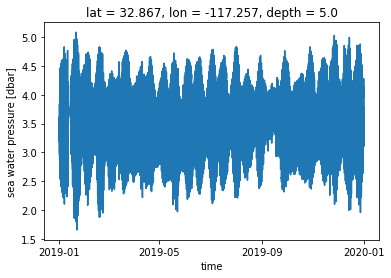

In [4]:
ds['pressure'].plot()

In [5]:
pressure = ds['pressure'].values
print(ds['pressure'])

<xarray.DataArray 'pressure' (time: 129487)>
array([3.578, 3.183, 3.333, ..., 3.332, 3.333, 3.171], dtype=float32)
Coordinates:
  * time     (time) object 2019-01-01 00:00:15 ... 2019-12-31 23:56:32
    lat      float32 ...
    lon      float32 ...
    depth    float32 ...
Attributes:
    platform:       platform1
    long_name:      sea water pressure
    standard_name:  sea_water_pressure
    instrument:     instrument1
    units:          dbar
    ncei_name:      PRESSURE - WATER
    source:         insitu observations
    cell_methods:   time: point
    references:     http://sccoos.org/data/autoss/, http://sccoos.org/about/d...
    grid_mapping:   crs
    comment:        The following QC tests were done on pressure: Range Check...
    valid_min:      0.0
    valid_max:      20.0
    data_max:       5.084
    data_min:       1.658
    _ChunkSizes:    1024


We could plot a histogram using the `matplotlib` function `hist` which allows us to specify the argument `density`. Let's see how to get both histogram and pdf of the pressure using `matplotlib`:

Text(0.5, 1.0, 'PDF')

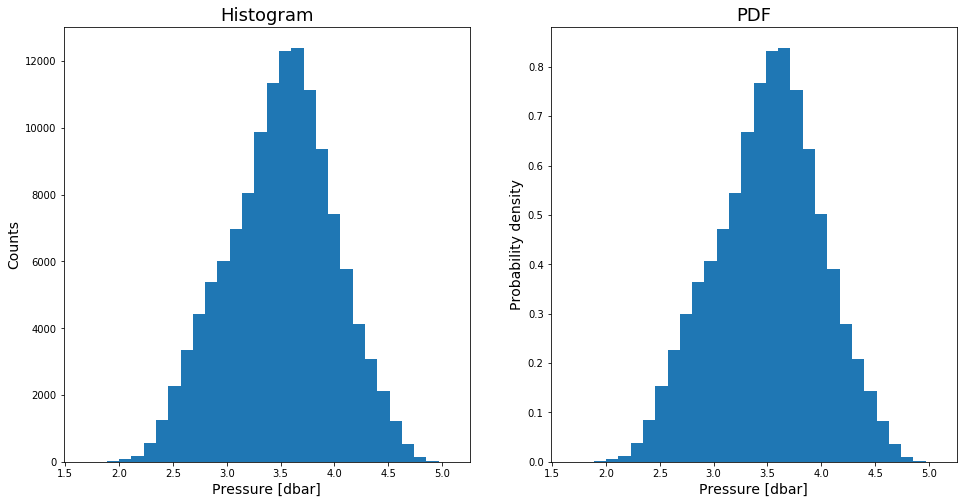

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (16, 8))
hist = ax1.hist(ds['pressure'].values, bins=30, density=False)
ax1.set_ylabel('Counts', fontsize=14)
ax1.set_xlabel('Pressure [%s]'%ds['pressure'].units, fontsize=14) # using the metadata
ax1.set_title('Histogram', fontsize=18)
# Now, with density=True
pdf  = ax2.hist(ds['pressure'].values, bins=30, density=True)
ax2.set_ylabel('Probability density', fontsize=14)
ax2.set_xlabel('Pressure [%s]'%ds['pressure'].units, fontsize=14)
ax2.set_title('PDF', fontsize=18)

Now, lets check if `density=True` is working properly. The function `hist` returns a tuple, where the first two elements are counts/pdf and bins.

In [7]:
values, bins, _ = pdf
dbin = bins[1] - bins[0]
print(values.sum()*dbin, 'is close enough to 1')

0.9999999031338814 is close enough to 1


You might want to have control over the bin width, so instead of passing the number of bins, you can pass a list representing the bin edges:

In [8]:
dbin1 = 0.1
bins1 = np.arange(ds['pressure'].min(), ds['pressure'].max(), dbin1).tolist()
dbin2 = 0.01
bins2 = np.arange(ds['pressure'].min(), ds['pressure'].max(), dbin2).tolist()

Text(0.5, 1.0, 'PDF')

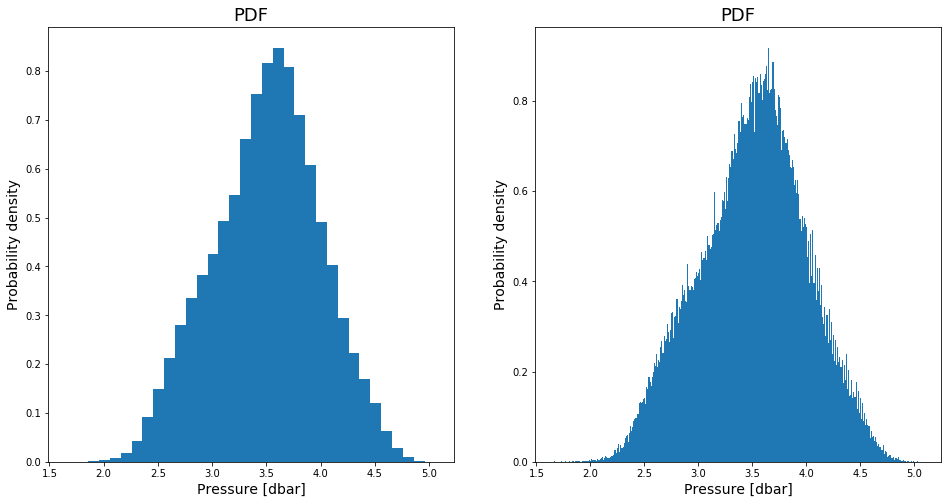

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (16, 8))
pdf1 = ax1.hist(ds['pressure'], bins=bins1, density=True)
ax1.set_ylabel('Probability density', fontsize=14)
ax1.set_xlabel('Pressure [%s]'%ds['pressure'].units, fontsize=14) # using the metadata
ax1.set_title('PDF', fontsize=18)
# Now, with narrower bins
pdf2  = ax2.hist(ds['pressure'], bins=bins2, density=True)
ax2.set_ylabel('Probability density', fontsize=14)
ax2.set_xlabel('Pressure [%s]'%ds['pressure'].units, fontsize=14)
ax2.set_title('PDF', fontsize=18)

My predecessor, Rob Pinkel, always told students that they couldn't use the ``hist`` function for this and should do a loop.  How do we do that?

Text(0, 0.5, 'counts')

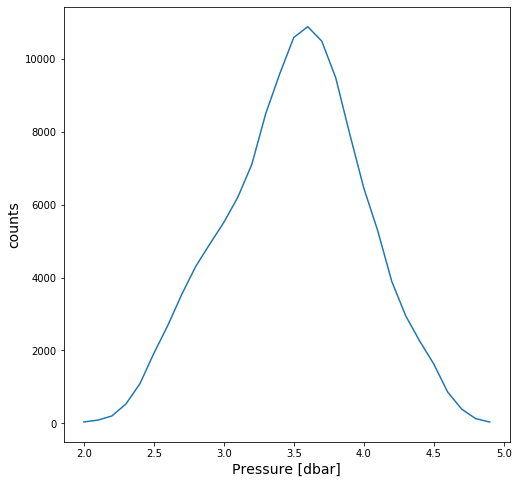

In [10]:
dbin = 0.1
bin_min = 2
bin_max = 5
bins = np.arange(bin_min, bin_max, dbin)
count = []
for i in range(len(bins)):
    ind = (pressure>bins[i] - dbin/2) & (pressure<=bins[i]+dbin/2)
    count.append(ind.sum())
count = np.array(count)

plt.figure(figsize = (8,8))
plt.plot(bins, count)
plt.xlabel('Pressure [dbar]', fontsize=14)
plt.ylabel('counts',  fontsize=14)

Should we write a function to do that?

In [11]:
def compute_histogram(variable, bin_max, bin_min, dbin, pdf=False):
    
    """ Computes 1D histogram or probability density for a given variable.
        
    Keyword arguments:
    variable -- 1D array.
    bin_max -- maximum value for bins
    bin_min -- minimum value for bins
    dbin -- bin size
    pdf -- (default False)
    
    Returns:
    bins -- histogram bins
    counts -- either counts or probability density
        
    """
    bins = np.arange(bin_min, bin_max, dbin)
    count = []
    for i in range(len(bins)):
        ind = (variable>bins[i] - dbin/2) & (variable<=bins[i]+dbin/2)
        count.append(ind.sum())
    count = np.array(count)
    if pdf:
        norm_hist = count/count.sum()/dbin
        assert np.allclose(norm_hist.sum()*dbin, 1.0), "PDF doesn't sum to 1"
    
        return bins, norm_hist
    else:
        return bins, count    

We like to think that geophysical variables are normally distributed,
meaning that the distribution is:

$$\begin{equation}
p(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)\hspace{3cm} (5)
\end{equation}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.
So we can add a Gaussian to our plot:

Text(0, 0.5, 'Probability density')

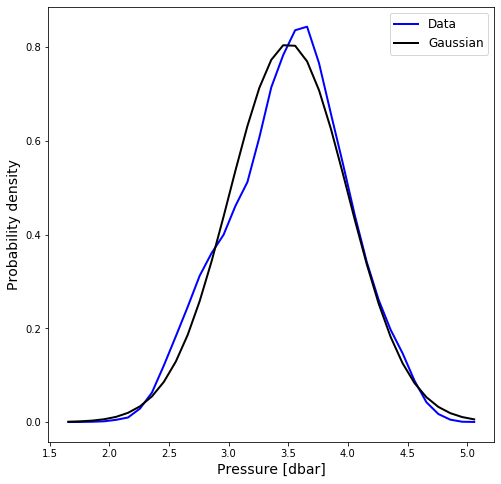

In [12]:
bins, norm_hist = compute_histogram(variable=pressure, bin_max=pressure.max(),
                                    bin_min=pressure.min(), dbin=0.1, pdf=True)

sig = np.std(pressure)
mu = np.mean(pressure)
gaus = (1.0/sig/np.sqrt(2*np.pi)) * (np.exp(-(bins-mu)**2 / (2*sig**2)))

plt.figure(figsize=(8, 8))
plt.plot(bins, norm_hist, 'b', lw=2, label='Data')
plt.plot(bins, gaus, 'k', lw=2, label='Gaussian')
plt.legend(fontsize=12)
plt.xlabel('Pressure [dbar]', fontsize=14)
plt.ylabel('Probability density',  fontsize=14)

We like the Gaussian, because it's easy to calculate, and it has well
defined properties.  We know that 68\% of measurements will be within
$\pm \sigma$ of the mean, and 95\% of measurements will be within $\pm 2\sigma$
of the mean.

We can turn this around to decide whether a measurement is
an outlier.  If we expect to see a lot of values near the mean, and we find that
we have a measurement that deviates from the mean by 5 $\sigma$, then it's
not terribly statistically likely.  (For a Gaussian, 99.99994\% of observations
should be within $\pm 5\sigma$ of the mean.)  Thus we might decide to throw
out all outliers that differ from the mean by more than 3 or 4 or 5$\sigma$.

We can also use this framework to think about uncertainty.  If we measure
one realization of an estimate of the mean, that will become our best estimate
of the mean.  If our formal estimate of our a priori uncertainty is correct
(and we might also call this $\sigma$, but let's use $\delta$ for now),
then we expect that
68\% of the time, our single observation should be within $\pm\delta$ of the
true value, and 95\% of the time, our single observation should be wihtin
$\pm2\delta$ of the true value.

And really, we like the Gaussian, because the convolution of a Gaussian
with another Gaussian is still a Gaussian, so we can manipulate the
statistics easily.  But are data necessarily normally distributed? So this might lead you to think that all data are fairly Gaussian.

### Example pdfs of real data? Non-Gaussian cases.
Now what if we plot chlorophyll?

The quality control of the Chlorophyll measurements in this dataset is provided in a separate variable `chlorophyll_flagPrimary`. So let's check what is the meaning of this flag:

In [13]:
ds['chlorophyll_flagPrimary']

<xarray.DataArray 'chlorophyll_flagPrimary' (time: 129487)>
[129487 values with dtype=float32]
Coordinates:
  * time     (time) object 2019-01-01 00:00:15 ... 2019-12-31 23:56:32
    lat      float32 ...
    lon      float32 ...
    depth    float32 ...
Attributes:
    long_name:      sea water chlorophyll, qc primary flag
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water status_flag
    flag_meanings:  GOOD_DATA UNKNOWN SUSPECT BAD_DATA MISSING
    flag_values:    [1 2 3 4 9]
    comment:        Quality Control test are based on IOOS's Quality Control ...
    source:         QC results
    references:     https://github.com/ioos/qartod
    _ChunkSizes:    4096

So, it looks like the flag for good data is 1. Below we sellect only thw good values.

In [14]:
flag = ds['chlorophyll_flagPrimary'].values==1
good_chl = ds['chlorophyll'].values[flag]
bins = np.linspace(good_chl.min(), good_chl.max(), 30)
chl_mu = np.mean(good_chl)
chl_sig = np.std(good_chl)
chl_gaus = (1.0/chl_sig/np.sqrt(2*np.pi)) * (np.exp(-(bins-chl_mu)**2 / (2*chl_sig**2)))

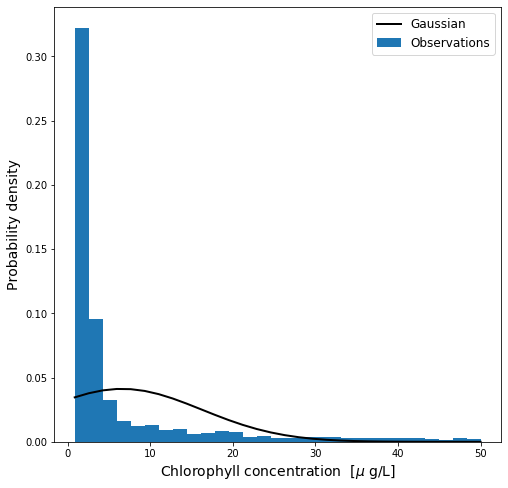

In [15]:
plt.figure(figsize=(8, 8))
hist = plt.hist(good_chl, bins=bins, density=True, label = 'Observations')
plt.plot(bins, chl_gaus, 'k', lw=2, label='Gaussian')
plt.xlabel('Chlorophyll concentration  [$\mu$ g/L]', fontsize=14)
plt.ylabel('Probability density',  fontsize=14)
plt.legend(fontsize=12)

As illustrated above, chlorophyll concentrations are decidedly non-Gaussian.  (We usually
refer to chlorophyll as being log-normally distributed, meaning that the
log of the values might be Gaussian.)

Ocean velocity data often have a double-exponential distribution, as do
wind velocity data:

$$\begin{equation}
p(x)=\frac{1}{\sigma\sqrt{2}} \exp{\left[-\frac{\left|x\right|\sqrt{2}}{\sigma} \right]}. \hspace{3cm} (6)
\end{equation}$$

Sometimes we only measure wind speed, and that's necessarily positive.
The Rayleigh distribution is sometimes a good representation of wind
speed:  it is defined from the square root sum of two independent
Gaussian components squared, $y=\sqrt{x_1^2 + x_2^2}$.
$$\begin{equation}
p(y)=\frac{y}{\sigma^2} \exp{\left[-\frac{y^2}{2\sigma^2} \right]}.\hspace{3cm} (7)
\end{equation}$$

### Summing variables, error propagation, and the central limit theorem

Given that so many pdfs can be non-Gaussian, why do we spend so much
time talking about Gaussians?  There are two important reasons.

1. As noted above, the Gaussian is mathematically tractable.
2. Even though individual pdfs are non-Gaussian, if we sum enough variables, everything is Gaussian.  (This is the central limit theorem, which we'll get to next time.)


Often the quantities we study represent a summation of multiple
random variables.  For example, we're not interested in the instantaneous
temperature but the average over an hour or a day.  Thus we consider

$$\begin{equation}
x(k) = \sum_{i=1}^{N} a_i x_i(k),\hspace{3cm} (8)
\end{equation}$$

following the terminology of Bendat and Piersol, where $a_i$ is a
coefficient. The mean of $x$ is
$$\begin{equation}
\mu_x = E(x(k)) = E\left[\sum_{i=1}^{N} a_i x_i(k)\right] = \left[\sum_{i=1}^{N} a_i E(x_i(k))\right] =
\sum_{i=1}^{N} a_i \mu_i. \hspace{3cm} (9)
\end{equation}$$

and

$$\begin{equation}
\sigma_x^2 = E\left[(x(k)-\mu_x)^2\right] =
=E\left[\sum_{i=1}^{N} a_i (x_i(k)-\mu_i)\right]^2
= \sum_{i=1}^{N} a_i^2 \sigma_i^2. \hspace{3cm} (10)
\end{equation}$$

In doing this, we've carried out a little sleight of hand, by assuming
that for a large ensemble (as the number of elements used to define our
expectation value $E$ approaches $\infty$) the correlation between
$x_i$ and $x_j$ is zero so that the expectation value
$E[(x_i(k)-\mu_i)(x_j(k)-\mu_j)] = 0$ for $i\ne j$.

This gives us some simple rules of thumb:

#### *Standard error of the mean.*
Suppose that $a_i$ is an averaging operator and is equal to $1/N$, and
$\sigma_i$ is the same for all $i$.  Then

$$\begin{equation}
\sigma_x^2 =  \sum_{i=1}^{N} a_i^2 \sigma_i^2 = \frac{N\sigma_i^2}{N^2} =
\frac{\sigma_i^2}{N}.\hspace{3cm} (11)
\end{equation}$$

This means that the standard deviation of the mean, {\it the standard error
of the mean}, is $\sigma/\sqrt{N}$.

As a footnote to this, the {\it standard error of the variance} is
$\sigma^2\sqrt{2/(N-1)}$.

#### *Error Propagation*
Our consideration of the summed variables
gives us a rule for estimating uncertainties of computed quantities.  If
we sum a variety of measures together, then the overall uncertainty
will be determined by the square root of the sum of the squares:
\begin{equation}
\delta_y = \sqrt{\sum_{i=1}^{N} a_i^2 \delta_i^2},
\end{equation}
where here we're using $\delta_i$ to represent the a priori uncertainties. 

What if we have to multiply quantities together?  Then we simply
linearize about the value of interest. We'll do this properly next time.